In [1]:
import cv2
import random
import numpy as np
from helpers.limbus_detection import detect_limbus
from helpers.misc import jiggle_circle
from helpers.view_detection import get_view_mask
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
kcf_params = cv2.TrackerKCF_Params()
kcf_params.compressed_size = 1
kcf_params.desc_pca = cv2.TrackerKCF_GRAY
kcf_params.desc_npca = cv2.TrackerKCF_GRAY
kcf_params.resize = True
kcf_params.detect_thresh = 0.7

def reset_tracker(frame, view_mask=None):
    circle = detect_limbus(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), validation='inout',
                           validation_value_thresh=40, view_mask=view_mask)
    if circle is None:
        return None

    tracker = cv2.TrackerKCF_create(kcf_params)
    bbox = (round(circle[0] - circle[2]), round(circle[1] - circle[2]), 
            round(circle[2]*2), round(circle[2]*2))
    tracker.init(frame, bbox)
    
    return tracker

In [4]:
filepath = '/Users/mirek/Desktop/test.mp4'
cap = cv2.VideoCapture(filepath)

_, frame = cap.read()
tracker = reset_tracker(frame)

In [5]:
while cap.isOpened():
    # Read a new frame
    ret, frame = cap.read() 
    if ret == False:
        break

    timer = cv2.getTickCount()

#     tracker = reset_tracker(frame)
    if tracker is None:
        ok = False
    else:
        ok, bbox = tracker.update(frame)
        
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if ok:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.circle(frame, (round(bbox[0] + bbox[2]/2), round(bbox[1] + bbox[3]/2)),
                   round((bbox[2] + bbox[3])/4), (255,0,0))
        cv2.putText(frame, "width v. height diff: %d" % abs(bbox[2] - bbox[3]),
                    (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,0,255) if abs(bbox[2] - bbox[3]) > 0 else (0,255,0),2)
        cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
        tracker = reset_tracker(frame)

    if fps < 20:
        tracker = None
        
    cv2.putText(frame, "KCF Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()                    
cv2.destroyAllWindows() 

### Circle jiggle

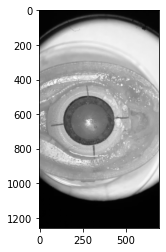

In [9]:
im = cv2.imread('/Users/mirek/Desktop/test3.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')

In [4]:
CORRECT_CIRCLE = np.array((265,370,235))
INIT_CIRCLE = np.array((300,300,235))

# CORRECT_CIRCLE = np.array((270,310,185))
# INIT_CIRCLE = np.array((300,300,185))

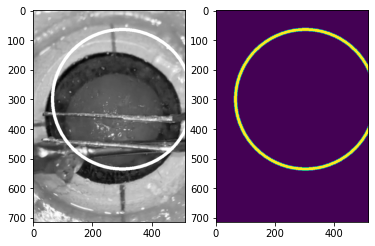

In [5]:
im_c = im.copy()
mask = np.zeros(im_c.shape, dtype=np.byte)
cv2.circle(im_c, (INIT_CIRCLE[0], INIT_CIRCLE[1]), INIT_CIRCLE[2], 255, 10)
cv2.circle(mask, (INIT_CIRCLE[0], INIT_CIRCLE[1]), INIT_CIRCLE[2], 1, 10)

_, axs = plt.subplots(1,2)
axs[0].imshow(im_c, cmap='gray')
axs[1].imshow(mask)

In [6]:
moments = cv2.moments(im*mask, False)
moments

{'m00': 2091263.0,
 'm10': 574852481.0,
 'm01': 532625433.0,
 'm20': 205848892019.0,
 'm11': 146158815057.0,
 'm02': 197537802893.0,
 'm30': 83842609905953.0,
 'm21': 53082687099617.0,
 'm12': 55570477726087.0,
 'm03': 86622536999949.0,
 'mu20': 47831763177.79001,
 'mu11': -250819505.3430786,
 'mu02': 61883008695.21738,
 'mu30': 961995772323.0781,
 'mu21': 792761435398.3887,
 'mu12': 1398472392920.5762,
 'mu03': 4789412040047.4375,
 'nu20': 0.010937021925793355,
 'nu11': -5.735139679374538e-05,
 'nu02': 0.014149924191962945,
 'nu30': 0.00015210781548252077,
 'nu21': 0.0001253490021541788,
 'nu12': 0.00022112215751850781,
 'nu03': 0.0007572871147843632}

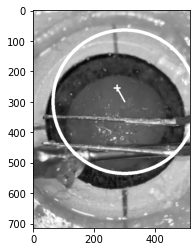

In [7]:
center = (round(moments['m10']/moments['m00']),
          round(moments['m01']/moments['m00']))
direction = (round(moments['m10']/moments['m00'] - INIT_CIRCLE[0]),
             round(moments['m01']/moments['m00'] - INIT_CIRCLE[1]))
im_cc = im_c.copy()
cv2.drawMarker(im_cc, center, 255, thickness=3)
cv2.line(im_cc, (INIT_CIRCLE[0], INIT_CIRCLE[1]), center, 255, thickness=3)

plt.imshow(im_cc, cmap='gray')

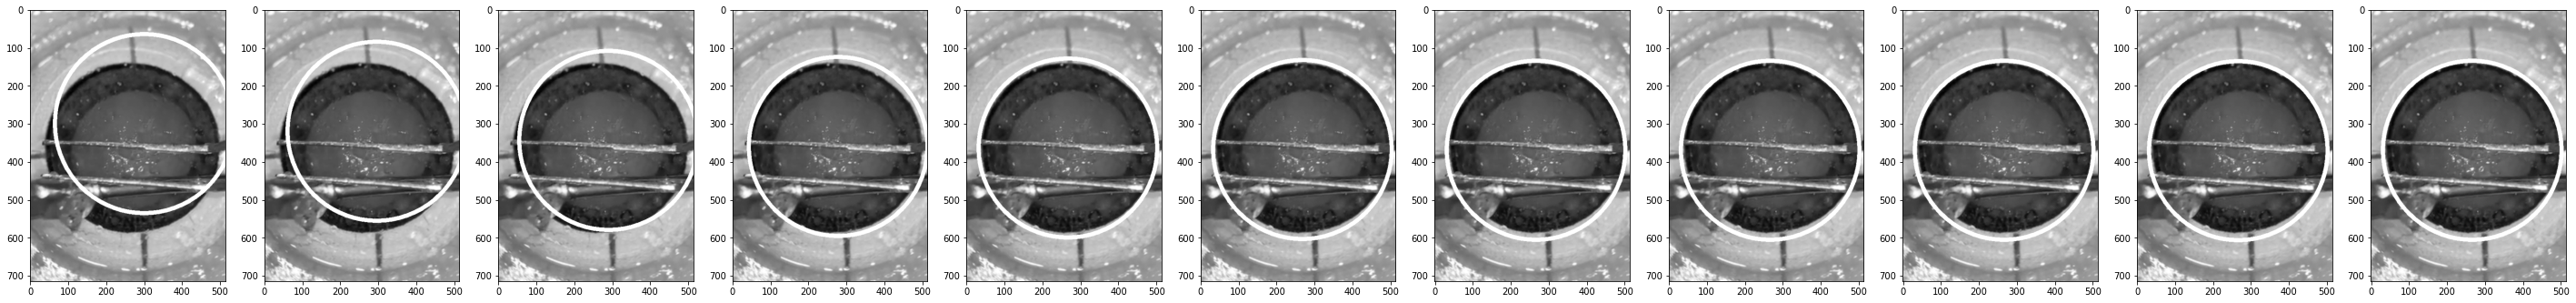

correct  [265 370 235] 
detected  [267.05383 370.4693  235.     ]


In [8]:
MAX_ITER = 10
ALPHA = 0.5

iter_ims = [im_c]
circle = np.copy(INIT_CIRCLE).astype('float32')
for _ in range(MAX_ITER):
    # pre edge treatment
    mask = np.zeros(im_c.shape, dtype=np.byte)
    cv2.circle(mask, (round(circle[0]), round(circle[1])), round(circle[2]), 1, 10)
    moments = cv2.moments(im*mask, False)
    
    # edge treatment
    padding = 0
    im_border = None
    if ((0 < round(circle[0]) - round(circle[2]) - 5) or
        (round(circle[0]) + round(circle[2]) + 5 >= im_c.shape[1]) or
        (0 < round(circle[1]) - round(circle[2]) - 5) or
        (round(circle[1]) + round(circle[2]) + 5 >= im_c.shape[0])):
        
        mean_value = moments['m00']/cv2.countNonZero(mask)
        padding = round(circle[2])*2 + 10
        im_border = cv2.copyMakeBorder(im, padding, padding, padding, padding, 
                                       cv2.BORDER_CONSTANT, value=round(mean_value))
        mask = np.zeros(im_border.shape, dtype=np.byte)
        cv2.circle(mask, (round(circle[0]) + padding, round(circle[1]) + padding), round(circle[2]), 1, 10)
        moments = cv2.moments(im_border*mask, False)

    # post edge treatment
    direction = np.array((moments['m10']/moments['m00'] - circle[0] - padding,
                          moments['m01']/moments['m00'] - circle[1] - padding))
    circle[:2] -= ALPHA*direction
    
    im_new = im.copy()
    cv2.circle(im_new, (round(circle[0]), round(circle[1])), round(circle[2]), 255, 10)
    iter_ims.append(im_new)
    
_, axs = plt.subplots(1, len(iter_ims), figsize=(50,10))
for i in range(len(iter_ims)):
    axs[i].imshow(iter_ims[i], cmap='gray')

plt.show()
print('correct ', CORRECT_CIRCLE, '\ndetected ', circle)

### View masking

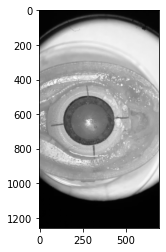

In [12]:
im_view = cv2.imread('/Users/mirek/Desktop/test3.png')
im_view = cv2.cvtColor(im_view, cv2.COLOR_BGR2GRAY)
plt.imshow(im_view, cmap='gray')

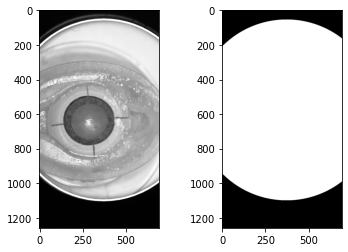

In [22]:
circle = detect_limbus(im_view, validation='inout', validation_mode='min')
im_view_c = im_view.copy()
mask = np.zeros(im_view_c.shape, dtype=np.byte)

cv2.circle(im_view_c, (round(circle[0]), round(circle[1])), round(circle[2]), 255, 10)
cv2.circle(mask, (round(circle[0]), round(circle[1])), round(circle[2]), 1, cv2.FILLED)

_, axs = plt.subplots(1, 2)
axs[0].imshow(im_view_c, cmap='gray')
axs[1].imshow(mask, cmap='gray')

### KFC tracking with circle jiggle

22.029336734693878 80.70052679798442
24.056836522942127 91.9729449689155
18.336642807665665 86.79539170506912
9.770135009310987 72.69058864186154
46.20241131463019 103.29370549046635
27.14739281575898 85.72995296546978
69.41872832369943 110.29279486002754
63.38216706882684 154.58069278818854
7.735465795003503 34.94775774387425
119.19854829704076 129.88315098468271
16.78441860465116 26.204718066743382
112.7108095985647 124.67098047817504
75.58381502890174 111.03999085923218
8.77854307728228 70.95977808599167
104.27009463003078 169.88281690140846
107.49035148173674 127.08615209988649
18.93633002079963 88.79635608856088
148.10182547219586 163.3323344011574
133.92465106516948 147.9540171288744
144.63178166611644 160.48610034333814
147.42877745728867 162.40184757505773
134.67136048526862 150.6335020242915
139.12160385626643 153.38770840143837
140.88695652173914 161.46090811391724
144.18519074797237 157.68150684931507
141.48285322359396 158.40560090937274
164.96263643996642 133.5472508591065

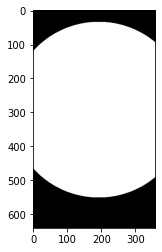

In [14]:
filepath = '/Users/mirek/Desktop/bioniko_input_long.mp4'
cap = cv2.VideoCapture(filepath)

_, frame = cap.read()
view_mask = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
tracker = reset_tracker(frame, view_mask=view_mask)

plt.imshow(view_mask, cmap='gray')

In [13]:
while cap.isOpened():
    # Read a new frame
    ret, frame = cap.read() 
    if ret == False:
        break

    timer = cv2.getTickCount()

#     tracker = reset_tracker(frame)
    if tracker is None:
        ok = False
    else:
        ok, bbox = tracker.update(frame)
        
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if ok:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        circle = jiggle_circle(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
                               np.array((bbox[0] + bbox[2]/2, 
                                         bbox[1] + bbox[3]/2, 
                                         (bbox[2] + bbox[3])/4)),
                              view_mask=view_mask)
        cv2.circle(frame, (round(circle[0]), round(circle[1])), round(circle[2]), (255,0,0),2)
        cv2.putText(frame, "width v. height diff: %d" % abs(bbox[2] - bbox[3]),
                    (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,0,255) if abs(bbox[2] - bbox[3]) > 0 else (0,255,0),2)
#         cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
        tracker = reset_tracker(frame, view_mask=view_mask)

    if fps < 20:
        tracker = None
        
    cv2.putText(frame, "KCF Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()                    
cv2.destroyAllWindows() 